In [1]:
!pip install xarray zarr dask matplotlib aiohttp hvplot datashader geoviews panel holoviews jupyter_bokeh bokeh pyviz_comms

In [2]:
import xarray as xr
import zarr
import aiohttp
import xarray.backends.zarr


In [3]:
test_dataset_public = xr.open_zarr(
    "https://hpfx.collab.science.gc.ca/~sbf000/zarr/20260121T16Z_MSC_Nowcast-WEonG_AllVar-WINGS_Sfc_RLatLon0.02.zarr",
    chunks={}
)
test_dataset_public

<xarray.Dataset> Size: 5GB
Dimensions:                      (time: 7, rlat: 1290, rlon: 2540)
Coordinates:
  * time                         (time) datetime64[ns] 56B 2026-01-21T16:00:0...
  * rlat                         (rlat) float32 5kB -12.3 -12.28 ... 16.68 16.7
  * rlon                         (rlon) float32 10kB -14.82 -14.8 ... 42.31
    lat                          (rlat, rlon) float32 13MB dask.array<chunksize=(323, 635), meta=np.ndarray>
    lon                          (rlat, rlon) float32 13MB dask.array<chunksize=(323, 635), meta=np.ndarray>
Data variables: (12/50)
    AirTemp                      (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
    BlowingSnow-Presence         (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
    BlowingSnow-Prob             (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
    CloudPrecipType              (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
    DewPoint                     (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
    Drizzle-Prob1h               (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
    ...                           ...
    UVIndex                      (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
    UVIndex-ClearSky             (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
    WindChill                    (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
    WindDir                      (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
    WindGust                     (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
    WindSpeed                    (time, rlat, rlon) float32 92MB dask.array<chunksize=(7, 1290, 2540), meta=np.ndarray>
Attributes: (12/21)
    Conventions:                             CF-1.8
    title:                                   Nowcast-WEonG_AllVar-WINGS_Sfc_R...
    institution:                             Environment and Climate Change C...
    source:                                  /home/smco500/.suites/hrdps_nati...
    history:                                 2026-01-21T17:20:13Z: Dataset cr...
    references:                              https://open.canada.ca/data/en/d...
    ...                                      ...
    extent_resy:                             0.02
    extent_resx:                             0.02
    rotated_pole_earth_radius:               6370997.0
    rotated_pole_grid_north_pole_latitude:   36.08852040966241
    rotated_pole_grid_north_pole_longitude:  65.30514195843372
    rotated_pole_north_pole_grid_longitude:  0.0

We can process and plot a portion of the data in a few lines of code.

In [4]:
orography = test_dataset_public["Orography"].isel(time=0)
orography

# world_population_2020 = orography.sum("age_band_lower_bound")

# world_population_2020.plot(vmax=500_000)

<xarray.DataArray 'Orography' (rlat: 1290, rlon: 2540)> Size: 13MB
dask.array<getitem, shape=(1290, 2540), dtype=float32, chunksize=(1290, 2540), chunktype=numpy.ndarray>
Coordinates:
  * rlat     (rlat) float32 5kB -12.3 -12.28 -12.26 -12.24 ... 16.66 16.68 16.7
  * rlon     (rlon) float32 10kB -14.82 -14.8 -14.78 ... 42.26 42.28 42.31
    lat      (rlat, rlon) float32 13MB dask.array<chunksize=(323, 635), meta=np.ndarray>
    lon      (rlat, rlon) float32 13MB dask.array<chunksize=(323, 635), meta=np.ndarray>
    time     datetime64[ns] 8B 2026-01-21T16:00:00
Attributes: (12/13)
    long_name:        Model orography
    units:            m
    standard_name:    Orography
    grid_mapping:     rotated_pole_grid
    cell_methods:     time: point
    valid_min:        -5.643898010253906
    ...               ...
    Conventions:      CF-1.8
    nomvar:           ME
    codes:            
    level:            0.0
    available_times:  ['2026-01-21T16:00', '2026-01-21T17:00', '2026-01-21T18...
    cumul_method:     zero

Note that we performed several operations:
* selection: we choose the variable `orography` and the date `2026-01-21T16:00:00`
* display: we plotted the data with simple configuration options

We can now test plotting the private dataset.

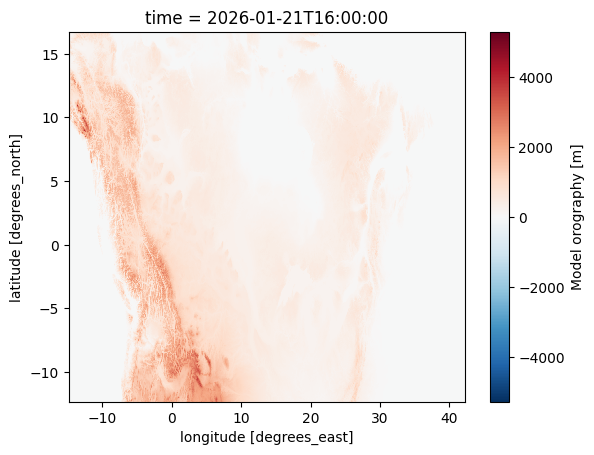

In [5]:
orography.plot()

Let's plot the average temperature anomaly on an area of interest defined as a latitude-longitude rectangle. For example Europe:

In [6]:
aoi_selection = {
    "lat": slice(60, 49),
    "lon": slice(-125, -110),
}

Plot a single month to check the geografic selection:

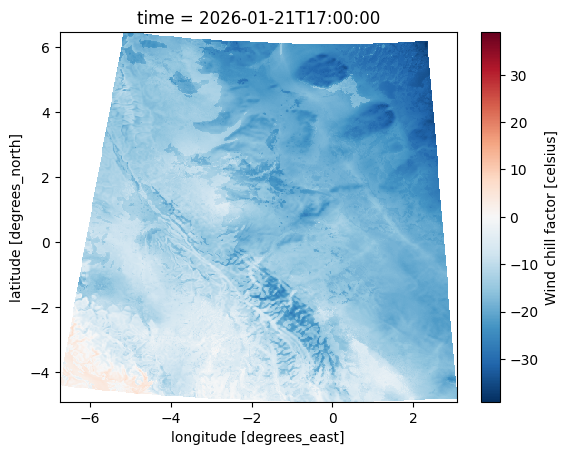

In [7]:
# The dataset's `lat` and `lon` are 2D data variables, not 1D coordinates,
# so direct .sel(lat=slice(...), lon=slice(...)) does not work.
# Instead, we need to create a boolean mask based on these 2D coordinates.

# Extract min/max from the aoi_selection slices
min_lat = min(aoi_selection['lat'].start, aoi_selection['lat'].stop)
max_lat = max(aoi_selection['lat'].start, aoi_selection['lat'].stop)
min_lon = min(aoi_selection['lon'].start, aoi_selection['lon'].stop)
max_lon = max(aoi_selection['lon'].start, aoi_selection['lon'].stop)

# Create a boolean mask for the geographic region and compute it
geographic_mask = ((test_dataset_public['lat'] >= min_lat) & \
                  (test_dataset_public['lat'] <= max_lat) & \
                  (test_dataset_public['lon'] >= min_lon) & \
                  (test_dataset_public['lon'] <= max_lon)).compute()

# Apply the mask to the WindChill data variable, and drop grid points outside the selection
aoi_windchill = test_dataset_public.WindChill.isel(time=1).where(geographic_mask, drop=True)

aoi_windchill.plot()

In [8]:
import cartopy.crs as ccrs
gmap = test_dataset_public.rotated_pole_grid
radius = gmap.attrs.get('earth_radius',None)
globe = ccrs.Globe(ellipse="sphere",semimajor_axis=radius,semiminor_axis=radius)
proj = ccrs.RotatedPole (pole_longitude = gmap.attrs['rotated_pole_grid_north_pole_longitude'], pole_latitude = gmap.attrs['rotated_pole_grid_north_pole_latitude'], central_rotated_longitude=gmap.attrs.get('rotated_pole_north_pole_grid_longitude',0.), globe=globe)


In [9]:
import panel as pn
import holoviews as hv

pn.extension(comms='colab') # Use this for Colab to ensure communication works
hv.extension('bokeh')
import hvplot.xarray
test_dataset_public.unify_chunks().WindChill.hvplot.quadmesh(title=f"{test_dataset_public.unify_chunks().WindChill.attrs['long_name']}", datashade=True, features=["coastline", "borders"], crs=proj, widget_location="bottom")

Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom')
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(name='time', options={'2026-01-21 16:00:00': np...}, value=np.datetime64('2026-01-21T...)

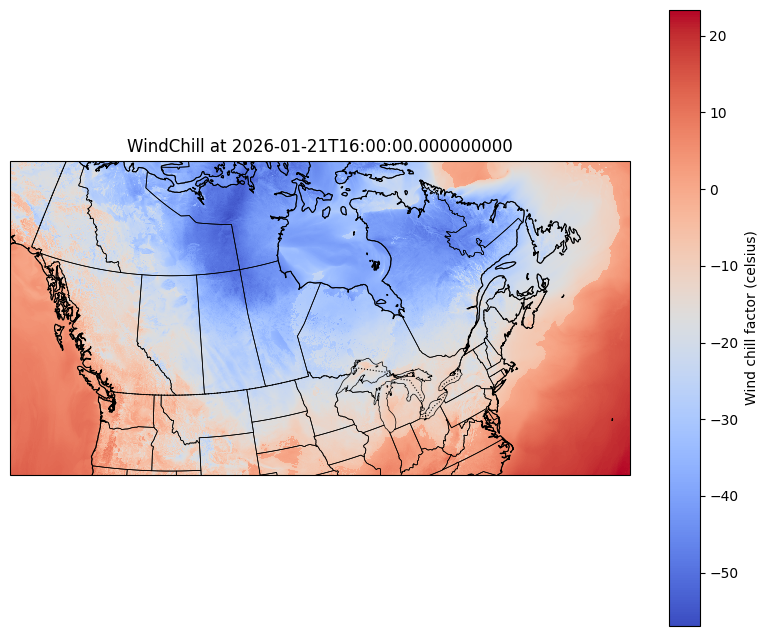

In [10]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

# Select WindChill data for time=0
wind_chill_data = test_dataset_public['WindChill'].isel(time=0)

# Create a figure and an axes with the rotated pole projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the WindChill data
# Use pcolormesh and transform the data coordinates to PlateCarree (WGS84)
# because the data's lat/lon are WGS84 and the proj is the target projection.
im = ax.pcolormesh(
    wind_chill_data['lon'], wind_chill_data['lat'], wind_chill_data,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm'
)

# Add geographic features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8)
ax.add_feature(cfeature.STATES, linewidth=0.5)
# ax.add_feature(cfeature.PROVINCES, linewidth=0.5) # Add province boundaries

# Add colorbar and title
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label(f"{wind_chill_data.attrs['long_name']} ({wind_chill_data.attrs['units']})")
ax.set_title(f"WindChill at {wind_chill_data['time'].values}")

plt.show()

### Plotting WindChill temporal series over Montreal

In [11]:
# Define the Area of Interest for Montreal
montreal_aoi_selection = {
    "lat": slice(46, 45),  # Latitude range for Montreal
    "lon": slice(-74.5, -72.5), # Longitude range for Montreal
}

# Extract min/max from the Montreal AOI slices
min_lat_mtl = min(montreal_aoi_selection['lat'].start, montreal_aoi_selection['lat'].stop)
max_lat_mtl = max(montreal_aoi_selection['lat'].start, montreal_aoi_selection['lat'].stop)
min_lon_mtl = min(montreal_aoi_selection['lon'].start, montreal_aoi_selection['lon'].stop)
max_lon_mtl = max(montreal_aoi_selection['lon'].start, montreal_aoi_selection['lon'].stop)

# Create a boolean mask for the Montreal geographic region and compute it
montreal_geographic_mask = ((test_dataset_public['lat'] >= min_lat_mtl) & \
                            (test_dataset_public['lat'] <= max_lat_mtl) & \
                            (test_dataset_public['lon'] >= min_lon_mtl) & \
                            (test_dataset_public['lon'] <= max_lon_mtl)).compute()

# Apply the mask to the WindChill data variable, keeping all time steps, and drop grid points outside the selection
montreal_windchill_area = test_dataset_public.WindChill.where(montreal_geographic_mask, drop=True)

montreal_windchill_area

<xarray.DataArray 'WindChill' (time: 7, rlat: 70, rlon: 76)> Size: 149kB
dask.array<where, shape=(7, 70, 76), dtype=float32, chunksize=(7, 70, 76), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 56B 2026-01-21T16:00:00 ... 2026-01-21T22:...
  * rlat     (rlat) float32 280B -1.12 -1.098 -1.075 ... 0.3875 0.41 0.4325
  * rlon     (rlon) float32 304B 26.65 26.67 26.69 26.71 ... 28.29 28.31 28.33
    lat      (rlat, rlon) float32 21kB 45.29 45.27 45.26 ... 45.73 45.71 45.7
    lon      (rlat, rlon) float32 21kB -75.1 -75.08 -75.05 ... -71.91 -71.89
Attributes: (12/13)
    long_name:        Wind chill factor
    units:            celsius
    standard_name:    WindChill
    grid_mapping:     rotated_pole_grid
    cell_methods:     time: point
    valid_min:        -56.944087982177734
    ...               ...
    Conventions:      CF-1.8
    nomvar:           RE
    codes:            
    level:            0.0
    available_times:  ['2026-01-21T16:00', '2026-01-21T17:00', '2026-01-21T18...
    cumul_method:     ip2_minus_ip3

In [12]:
import numpy as np
import hvplot.xarray

# Calculate the cosine of the latitude for weighting (using the lat variable from the filtered data)
montreal_lat_lon_weight = np.cos(np.deg2rad(montreal_windchill_area['lat']))

# Calculate the weighted mean over the rlat and rlon dimensions for all time steps
montreal_mean_windchill_series = montreal_windchill_area.weighted(montreal_lat_lon_weight).mean(
    ["rlat", "rlon"]
)

# Add attributes for clarity
montreal_mean_windchill_series.attrs["long_name"] = "Mean WindChill over Montreal"
montreal_mean_windchill_series.attrs["units"] = test_dataset_public['WindChill'].attrs['units'] # Use original units

# Plot the temporal series
montreal_mean_windchill_series.hvplot.line(title=f"{montreal_mean_windchill_series.attrs['long_name']} ({montreal_mean_windchill_series.attrs['units']})")

:Curve   [time]   (Mean WindChill over Montreal)